In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import datetime
import scipy
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
#from keras.utils.vis_utils import plot_model
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

In [2]:
# 1. Load Raw Data
csv_raw = pd.read_csv("./data/data_2024_clear2.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)
#csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# 2. extract usable raw component(columns) ordered by datatime
raw_data = csv_raw[['datetime', 'warmup', 'off', 
                   'add_amount_brightener', 'add_amount_carrier', 
                   'velocity','tension','v','a','temperature',
                   'copper_sulfate_content', 'sulfuric_acid_content', 'chloride_content']].sort_values("datetime")

# 3. extracted column data, remove NaN
raw_warmup = raw_data[~raw_data["warmup"].isna()][["datetime", "warmup"]]
raw_off = raw_data[~raw_data["off"].isna()][["datetime", "off"]]
raw_brightener = (raw_data[~raw_data["add_amount_brightener"].isna()])[["datetime", "add_amount_brightener"]]
raw_carrier = (raw_data[~raw_data["add_amount_carrier"].isna()])[["datetime", "add_amount_carrier"]]
raw_velocity = (raw_data[~raw_data["velocity"].isna()])[["datetime", "velocity"]]
raw_tension = (raw_data[~raw_data["tension"].isna()])[["datetime", "tension"]]
raw_voltage = (raw_data[~raw_data["v"].isna()])[["datetime", "v"]]
raw_ampere = (raw_data[~raw_data["a"].isna()])[["datetime", "a"]]
raw_temperature = (raw_data[~raw_data["temperature"].isna()])[["datetime", "temperature"]]
raw_cs = (raw_data[~raw_data["copper_sulfate_content"].isna()])[["datetime", "copper_sulfate_content"]]
raw_sa = (raw_data[~raw_data["sulfuric_acid_content"].isna()])[["datetime", "sulfuric_acid_content"]]
raw_c = (raw_data[~raw_data["chloride_content"].isna()])[["datetime", "chloride_content"]]



In [3]:

pd.set_option('display.max_rows', None)  # 모든 행을 출력
pd.set_option('display.max_columns', None) # 모든 열을 출력
pd.set_option('display.width', 200)

#4. Create new data frame (for every single day operation)
raw_ext = pd.DataFrame(dtype=float, columns=['datetime', 'optime', 'optime_min', 'add_amount_brightener', 'add_amount_carrier', 
                                             'velocity', 'velocity_var', 'velocity_std',
                                             'tension','tension_var', 'tension_std',
                                             'voltage','voltage_var', 'voltage_std',
                                             'ampere','ampere_var', 'ampere_std',
                                             'temperature','temperature_var', 'temperature_std',
                                             'cs','cs_var', 'cs_std',
                                             'sa','sa_var', 'sa_std',
                                             'ch','c_var', 'c_std'])

#5. Calculate operation time (every single day)
for warmup, off in zip(raw_warmup.iterrows(), raw_off.iterrows()):
    value = [off[1]["datetime"], off[1]["datetime"]-warmup[1]["datetime"]] # 단위작업 시간을 기준으로 시간을 쪼개서 구분
    value.extend([np.nan for i in range(0, raw_ext.shape[1]-len(value))]) # 사전에 설정한 컬럼에 row를 모두 nan으로 채움
    raw_ext.loc[len(raw_ext.index)] = value # raw_ext에 하나씩 쌓음 (총 115번 작업)
    

raw_ext = raw_ext.groupby(pd.Grouper(key='datetime', freq='D', sort=True, )).sum() #같은 날짜에 두번작업하는 경우가 많아, 같은 날짜는 sum (key로 지정되었던 datetime은 컬럼에서 사라지고 index로 지정됨, 해제하려면 reset_index() 추가)
raw_ext = raw_ext[raw_ext["optime"]>datetime.timedelta(seconds=0)] # drop no timedelta, 작업시간이 0초보다 큰 경우에만 남겨둠. (115개 작업이 68개로 줄어듬. 총 68일에 해당하는 데이터)
raw_ext["optime_min"] = [i.total_seconds()/60 for i in raw_ext.loc[:,"optime"]] # add time min # 작업시간을 분으로 재표현
raw_ext = raw_ext.drop(columns="optime") # optime 컬럼 제거



In [4]:


for t_idx in raw_ext.index: # 중복없는 datetime index를 기준으로 해당 날짜에 대한 데이터 추출
    mask_brightener = list((raw_brightener["datetime"]>t_idx) & (raw_brightener["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_carrier = list((raw_carrier["datetime"]>t_idx) & (raw_carrier["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_voltage = list((raw_voltage["datetime"]>t_idx) & (raw_voltage["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_ampere = list((raw_ampere["datetime"]>t_idx) & (raw_ampere["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_temperature = list((raw_temperature["datetime"]>t_idx) & (raw_temperature["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_tension = list((raw_tension["datetime"]>t_idx) & (raw_tension["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_velocity = list((raw_velocity["datetime"]>t_idx) & (raw_velocity["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_cs = list((raw_cs["datetime"]>t_idx) & (raw_cs["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_sa = list((raw_sa["datetime"]>t_idx) & (raw_sa["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_c = list((raw_c["datetime"]>t_idx) & (raw_c["datetime"]<=t_idx+datetime.timedelta(hours=24)))

    
    if any(mask_brightener):
        raw_ext.loc[t_idx, "add_amount_brightener"] = raw_brightener.loc[mask_brightener, "add_amount_brightener"].astype(float).values[0]
    if any(mask_carrier):
        raw_ext.loc[t_idx, "add_amount_carrier"] = raw_carrier.loc[mask_carrier, "add_amount_carrier"].astype(float).values[0]
    if any(mask_voltage):
        raw_ext.loc[t_idx, "voltage"] = raw_voltage.loc[mask_voltage, "v"].astype(float).values.mean()
        raw_ext.loc[t_idx, "voltage_var"] = raw_voltage.loc[mask_voltage, "v"].astype(float).values.var()
        raw_ext.loc[t_idx, "voltage_std"] = raw_voltage.loc[mask_voltage, "v"].astype(float).values.std()
    if any(mask_ampere):
        raw_ext.loc[t_idx, "ampere"] = raw_ampere.loc[mask_ampere, "a"].astype(float).values.mean()
        raw_ext.loc[t_idx, "ampere_var"] = raw_ampere.loc[mask_ampere, "a"].astype(float).values.var()
        raw_ext.loc[t_idx, "ampere_std"] = raw_ampere.loc[mask_ampere, "a"].astype(float).values.std()
    if any(mask_temperature):
        raw_ext.loc[t_idx, "temperature"] = raw_temperature.loc[mask_temperature, "temperature"].astype(float).values.mean()
        raw_ext.loc[t_idx, "temperature_var"] = raw_temperature.loc[mask_temperature, "temperature"].astype(float).values.var()
        raw_ext.loc[t_idx, "temperature_std"] = raw_temperature.loc[mask_temperature, "temperature"].astype(float).values.std()
    if any(mask_cs):
        raw_ext.loc[t_idx, "cs"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].astype(float).values.mean()
        raw_ext.loc[t_idx, "cs_var"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].astype(float).values.var()
        raw_ext.loc[t_idx, "cs_std"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].astype(float).values.std()
    if any(mask_sa):
        raw_ext.loc[t_idx, "sa"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].astype(float).values.mean()
        raw_ext.loc[t_idx, "sa_var"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].astype(float).values.var()
        raw_ext.loc[t_idx, "sa_std"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].astype(float).values.std()
    if any(mask_c):
        raw_ext.loc[t_idx, "ch"] = raw_c.loc[mask_c, "chloride_content"].astype(float).values.mean()
        raw_ext.loc[t_idx, "ch_var"] = raw_c.loc[mask_c, "chloride_content"].astype(float).values.var()
        raw_ext.loc[t_idx, "ch_std"] = raw_c.loc[mask_c, "chloride_content"].astype(float).values.std()
    if any(mask_velocity):
        raw_ext.loc[t_idx, "velocity"] = raw_velocity.loc[mask_velocity, "velocity"].astype(float).values.mean()
        raw_ext.loc[t_idx, "velocity_var"] = raw_velocity.loc[mask_velocity, "velocity"].astype(float).values.var()
        raw_ext.loc[t_idx, "velocity_std"] = raw_velocity.loc[mask_velocity, "velocity"].astype(float).values.std()
    if any(mask_tension):
        raw_ext.loc[t_idx, "tension"] = raw_tension.loc[mask_tension, "tension"].astype(float).values.mean()
        raw_ext.loc[t_idx, "tension_var"] = raw_tension.loc[mask_tension, "tension"].astype(float).values.var()
        raw_ext.loc[t_idx, "tension_std"] = raw_tension.loc[mask_tension, "tension"].astype(float).values.std()

/var/folders/6v/qy52vr7s2sd7g5_n5cm3dpwc0000gn/T/ipykernel_71576/7229835.py:21: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  optime_mean_normalized = optime_scaler.fit_transform(raw_prepared.loc[:,"optime_min"].ravel().reshape(-1, 1)).flatten()
/var/folders/6v/qy52vr7s2sd7g5_n5cm3dpwc0000gn/T/ipykernel_71576/7229835.py:22: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  add_amount_brightener_normalized = brightener_scaler.fit_transform(raw_prepared.loc[:,"add_amount_brightener"].ravel().reshape(-1, 1)).flatten()
/var/folders/6v/qy52vr7s2sd7g5_n5cm3dpwc0000gn/T/ipykernel_71576/7229835.py:23: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array inste

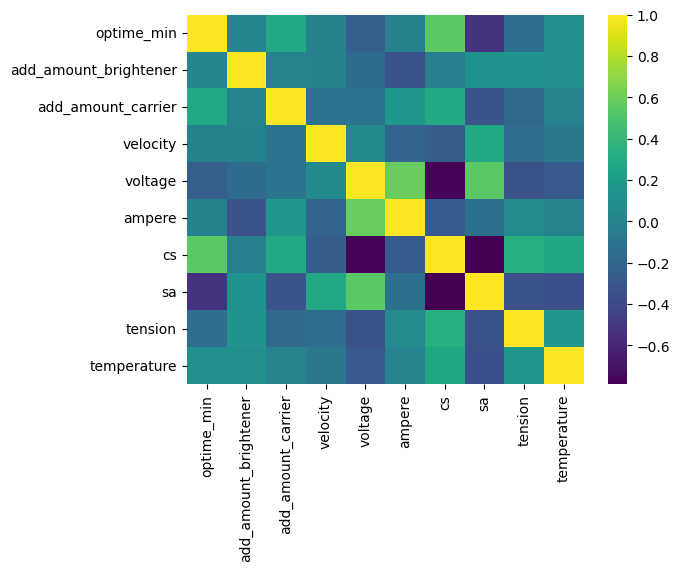

In [5]:

        
# 7. drop the row with nan value of add_amount_brightener
raw_prepared = raw_ext.loc[raw_ext["add_amount_brightener"]!=0.0]

# 7.1 save to csv file
raw_prepared.to_csv('./aggregate_2024.csv', sep=',')


# 8. stand scaler
optime_scaler = StandardScaler()
brightener_scaler = StandardScaler()
carrier_scaler = StandardScaler()
voltage_scaler = StandardScaler()
ampere_scaler = StandardScaler()
temperature_scaler = StandardScaler()
cs_scaler = StandardScaler()
sa_scaler = StandardScaler()
ch_scaler = StandardScaler()
velocity_scaler = StandardScaler()
tension_scaler = StandardScaler()

optime_mean_normalized = optime_scaler.fit_transform(raw_prepared.loc[:,"optime_min"].ravel().reshape(-1, 1)).flatten()
add_amount_brightener_normalized = brightener_scaler.fit_transform(raw_prepared.loc[:,"add_amount_brightener"].ravel().reshape(-1, 1)).flatten()
add_amount_carrier_normalized = carrier_scaler.fit_transform(raw_prepared.loc[:,"add_amount_carrier"].ravel().reshape(-1, 1)).flatten()
voltage_normalized = voltage_scaler.fit_transform(raw_prepared.loc[:,"voltage"].ravel().reshape(-1, 1)).flatten()
ampere_normalized = ampere_scaler.fit_transform(raw_prepared.loc[:,"ampere"].ravel().reshape(-1, 1)).flatten()
temperature_normalized = temperature_scaler.fit_transform(raw_prepared.loc[:,"temperature"].ravel().reshape(-1, 1)).flatten()
cs_normalized = cs_scaler.fit_transform(raw_prepared.loc[:,"cs"].ravel().reshape(-1, 1)).flatten()
sa_normalized = sa_scaler.fit_transform(raw_prepared.loc[:,"sa"].ravel().reshape(-1, 1)).flatten()
velocity_normalized = velocity_scaler.fit_transform(raw_prepared.loc[:,"velocity"].ravel().reshape(-1, 1)).flatten()
tension_normalized = tension_scaler.fit_transform(raw_prepared.loc[:,"tension"].ravel().reshape(-1, 1)).flatten()

# 9. correlation analysis
X = raw_prepared.loc[:,["optime_min", "add_amount_brightener", "add_amount_carrier", "velocity", "voltage", "ampere", "cs", "sa", "tension", "temperature"]]
corr = X.corr()
sns.heatmap(corr, cmap='viridis')
plt.show()

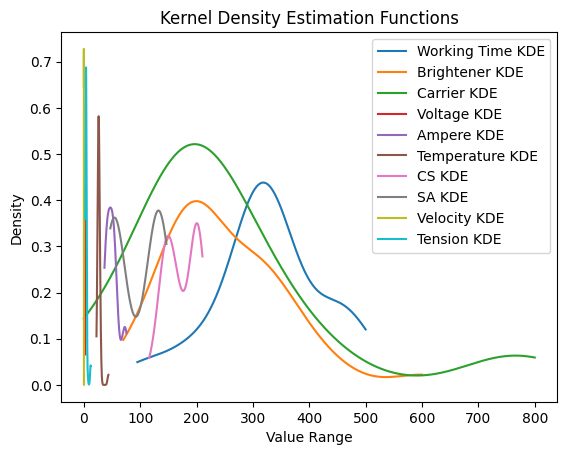

In [28]:
# kernel density estimation to resample more data
bw = 'scott'
optime_kde = gaussian_kde(optime_mean_normalized, bw_method=bw)
brightener_kde = gaussian_kde(add_amount_brightener_normalized, bw_method=bw)
carrier_kde = gaussian_kde(add_amount_carrier_normalized, bw_method=bw)
voltage_kde = gaussian_kde(voltage_normalized, bw_method=bw)
ampere_kde = gaussian_kde(ampere_normalized, bw_method=bw)
temperature_kde = gaussian_kde(temperature_normalized, bw_method=bw)
cs_kde = gaussian_kde(cs_normalized, bw_method=bw)
sa_kde = gaussian_kde(sa_normalized, bw_method=bw)
velocity_kde = gaussian_kde(velocity_normalized, bw_method=bw)
tension_kde = gaussian_kde(tension_normalized, bw_method=bw)

# resample from kde
n_sample = 2000

x_optime = np.linspace(min(optime_mean_normalized), max(optime_mean_normalized), n_sample)
x_brightener = np.linspace(min(add_amount_brightener_normalized), max(add_amount_brightener_normalized), n_sample)
x_carrier = np.linspace(min(add_amount_carrier_normalized), max(add_amount_carrier_normalized), n_sample)
x_voltage = np.linspace(min(voltage_normalized), max(voltage_normalized), n_sample)
x_ampere = np.linspace(min(ampere_normalized), max(ampere_normalized), n_sample)
x_temperature = np.linspace(min(temperature_normalized), max(temperature_normalized), n_sample)
x_cs = np.linspace(min(cs_normalized), max(cs_normalized), n_sample)
x_sa = np.linspace(min(sa_normalized), max(sa_normalized), n_sample)
x_velocity = np.linspace(min(velocity_normalized), max(velocity_normalized), n_sample)
x_tension = np.linspace(min(tension_normalized), max(tension_normalized), n_sample)

optime_df = optime_kde(x_optime)
brightener_df = brightener_kde(x_brightener)
carrier_df = carrier_kde(x_carrier)
voltage_df = voltage_kde(x_voltage)
ampere_df = ampere_kde(x_ampere)
temperature_df = temperature_kde(x_temperature)
cs_df = cs_kde(x_cs)
sa_df = sa_kde(x_sa)
velocity_df = velocity_kde(x_velocity)
tension_df = tension_kde(x_tension)


rx_optime = optime_scaler.inverse_transform(x_optime.reshape(1, -1)).flatten()
rx_brightener = brightener_scaler.inverse_transform(x_brightener.reshape(1, -1)).flatten()
rx_carrier = carrier_scaler.inverse_transform(x_carrier.reshape(1, -1)).flatten()
rx_voltage = voltage_scaler.inverse_transform(x_voltage.reshape(1, -1)).flatten()
rx_ampere = ampere_scaler.inverse_transform(x_ampere.reshape(1, -1)).flatten()
rx_temperature = temperature_scaler.inverse_transform(x_temperature.reshape(1, -1)).flatten()
rx_cs = cs_scaler.inverse_transform(x_cs.reshape(1, -1)).flatten()
rx_sa = sa_scaler.inverse_transform(x_sa.reshape(1, -1)).flatten()
rx_velocity = velocity_scaler.inverse_transform(x_velocity.reshape(1, -1)).flatten()
rx_tension = tension_scaler.inverse_transform(x_tension.reshape(1, -1)).flatten()


plt.plot(rx_optime, optime_df, label='Working Time KDE')
plt.plot(rx_brightener, brightener_df, label='Brightener KDE')
plt.plot(rx_carrier, carrier_df, label='Carrier KDE')
plt.plot(rx_voltage, voltage_df, label='Voltage KDE')
plt.plot(rx_ampere, ampere_df, label='Ampere KDE')
plt.plot(rx_temperature, temperature_df, label='Temperature KDE')
plt.plot(rx_cs, cs_df, label='CS KDE')
plt.plot(rx_sa, sa_df, label='SA KDE')
plt.plot(rx_velocity, velocity_df, label='Velocity KDE')
plt.plot(rx_tension, tension_df, label='Tension KDE')
plt.xlabel('Value Range')
plt.ylabel('Density')
plt.title('Kernel Density Estimation Functions')
plt.legend()
plt.show()

X_train:(1400, 8), y_train:(1400, 2), X_test:(600, 8), y_test:(600, 2)
Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.3782 - val_loss: 0.0705
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.0660 - val_loss: 0.0311
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.0348 - val_loss: 0.0161
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 0.0212 - val_loss: 0.0093
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0115 - val_loss: 0.0059
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0078 - val_loss: 0.0039
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.0047 - val_loss: 0.0027
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.0028 - val_loss: 0.0014
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 397u

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159 (640.00 B)

 Trainable params: 157 (628.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

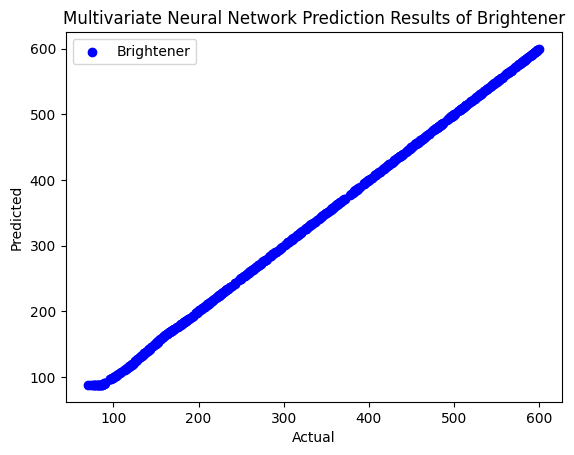

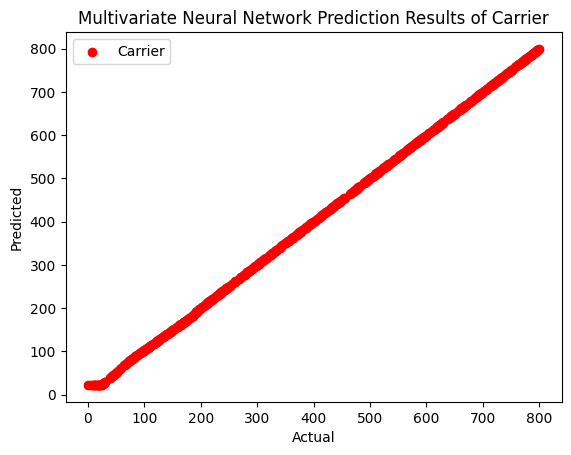

dict_keys(['loss', 'val_loss'])


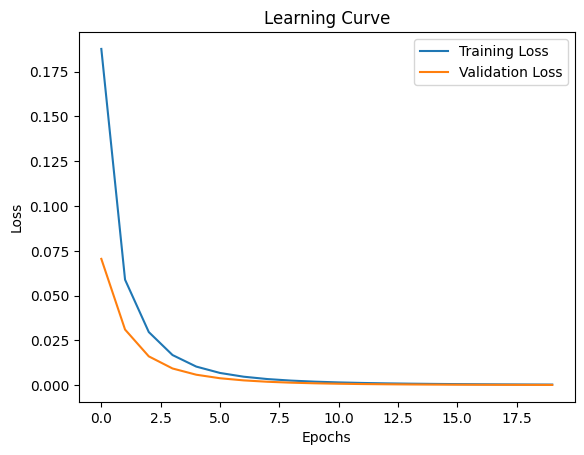

MAE of Carrier : 0.7100002273488548
MSE of Carrier : 3.5868256599797124
R-squared of Carrier : 0.9999348161944712
-------------------------------
MAE of Brightener : 0.5060083340620535
MSE of Brightener : 2.2908219836813246
R-squared of Brightener : 0.9999051474478928


In [29]:
# Modeling
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop


# correlation
X = pd.DataFrame([x_optime.T, x_voltage.T, x_ampere.T, x_temperature.T, x_cs.T, x_sa.T, x_tension.T, x_velocity.T]).T
y = pd.DataFrame([x_brightener.T, x_carrier.T]).T
X.columns = ['optime', 'voltage', 'Ampere', "Temperature", "copper_sulfate", "sulfuric_acid", "Tension", "Velocity"]
y.columns = ['brightener', 'carrier']

# corr = X.corr()
# sns.heatmap(corr, cmap='viridis', annot=True)
# plt.show()

# print(X)

# model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
model = models.Sequential()
model.add(layers.Input(shape=(X.shape[1],))) # input layer
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(y.shape[1], activation='linear'))


#plot_model(model, to_file="./model.png", show_shapes=True, show_layer_names=True)
model.compile(loss='mean_squared_error', optimizer='sgd')
print(f"X_train:{X_train.shape}, y_train:{y_train.shape}, X_test:{X_test.shape}, y_test:{y_test.shape}")
history = model.fit(X_train, y_train, epochs=20, batch_size=5, verbose=1, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)

# save model
model.save("model/mvnn.keras")
model.summary()

# output inverse transform
brightener_pred_output = brightener_scaler.inverse_transform(y_pred[:,0].reshape(1, -1)).flatten()
brightener_test_output = brightener_scaler.inverse_transform(y_test["brightener"].values.reshape(1, -1)).flatten()
carrier_pred_output = carrier_scaler.inverse_transform(y_pred[:,1].reshape(1, -1)).flatten()
carrier_test_output = carrier_scaler.inverse_transform(y_test["carrier"].values.reshape(1, -1)).flatten()

plt.scatter(brightener_test_output, brightener_pred_output, color='b', label='Brightener')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Multivariate Neural Network Prediction Results of Brightener')
plt.legend()
plt.show()

plt.scatter(carrier_test_output, carrier_pred_output, color='r', label='Carrier')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Multivariate Neural Network Prediction Results of Carrier')
plt.legend()
plt.show()

# learning curve
print(history.history.keys())
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# carrier_test_output_inverse = carrier_scaler.inverse_transform(carrier_test_output.reshape(-1,1))
# carrier_pred_output_inverse = carrier_scaler.inverse_transform(carrier_pred_output.reshape(-1,1))

#mae = mean_absolute_error(carrier_test_output, carrier_pred_output)
# mae = mean_absolute_error(carrier_test_output_inverse, carrier_pred_output_inverse)
# print(f"Carrier Mean Absolute Error : {mae}")

# mse = mean_squared_error(carrier_test_output_inverse, carrier_pred_output_inverse)
# print(f"Carrier Mean Squared Error : {mse}")

# r2 = r2_score(y_test, y_pred)
# print(f"Carrier R-squared Result : {r2}")

# vs = explained_variance_score(carrier_test_output, carrier_pred_output)
# print(f"Explained Variance Score : {vs}")



carrier_mae = mean_absolute_error(carrier_test_output, carrier_pred_output)
print(f"MAE of Carrier : {carrier_mae}")
carrier_mse = mean_squared_error(carrier_test_output, carrier_pred_output)
print(f"MSE of Carrier : {carrier_mse}")
carrier_r2 = r2_score(carrier_test_output, carrier_pred_output)
print(f"R-squared of Carrier : {carrier_r2}")
print("-------------------------------")
brightener_mae = mean_absolute_error(brightener_test_output, brightener_pred_output)
print(f"MAE of Brightener : {brightener_mae}")
brightener_mse = mean_squared_error(brightener_test_output, brightener_pred_output)
print(f"MSE of Brightener : {brightener_mse}")
brightener_r2 = r2_score(brightener_test_output, brightener_pred_output)
print(f"R-squared of Brightener : {brightener_r2}")


In [15]:
print(carrier_pred_output)


[413.3995    588.7232    591.16034   526.17096   330.36212   540.7936
 498.55054   407.0157    687.8319    109.00921   648.8384     67.951195
 506.6742    777.56805   752.00885   720.32666   217.44159   707.3287
 608.22      258.4612    435.9983    130.91142   301.41254   418.18732
 157.37059   175.745      88.87499   785.88605   722.7637    759.3202
 283.31906   110.73498   494.4887    395.84396   300.6888    148.55086
 548.10486   464.4311    721.9514     53.431145  267.897      85.03358
 251.0987    778.208     237.42548   214.28624   740.6358    478.2413
 350.6268    669.95984   453.05798   704.0793    197.45766   459.55698
  22.682793   28.66169   491.23923    11.579261  165.45534   656.14966
 234.27016    49.16053   430.31174   156.63559   480.67847   552.16675
 527.7958    693.51855    62.826485  431.1241     92.32656   391.0561
 469.3053    591.9727    230.06299   226.90765   519.672      36.348763
 468.49298   245.83978   541.606      59.40998   212.18268    60.264122
 257.409

In [16]:
print(carrier_test_output)

[417.21721722 590.19019019 592.59259259 528.52852853 329.12912913
 542.94294294 501.3013013  410.81081081 687.88788789 108.90890891
 649.44944945  60.86086086 509.30930931 779.17917918 751.15115115
 719.91991992 224.22422422 707.10710711 609.40940941 255.45545546
 439.63963964 139.33933934 297.0970971  422.02202202 168.16816817
 188.18818819  80.88088088 789.58958959 722.32232232 758.35835836
 277.07707708 111.31131131 497.2972973  399.5995996  296.2962963
 158.55855856 550.15015015 467.66766767 721.52152152  47.24724725
 262.66266266  76.87687688 249.84984985 779.97997998 239.43943944
 221.82182182 739.93993994 481.28128128 351.55155155 670.27027027
 456.45645646 703.9039039  209.00900901 462.86286286  18.41841842
  24.02402402 494.09409409   8.00800801 176.97697698 656.65665666
 237.03703704  43.24324324 434.03403403 167.36736737 483.68368368
 554.15415415 530.13013013 693.49349349  56.05605606 434.83483483
  85.68568569 394.79479479 472.47247247 593.39339339 233.83383383
 231.431431

In [270]:
# load model and prediction test
from tensorflow.keras import models


model = models.load_model(filepath="model/mvnn.keras")
model.summary()
# ['optime', 'voltage', 'Ampere', "Temperature", "copper_sulfate", "sulfuric_acid", "Tension", "Velocity"]
# 운영시간, 전압, 전류, 온도, 황산동함유량, 황산함유량, 장력, 속도
input = [optime_scaler.transform(np.array([[8.0]])).flatten()[0], 
         voltage_scaler.transform(np.array([[2.1]])).flatten()[0], 
         ampere_scaler.transform(np.array([[41]])).flatten()[0], 
         temperature_scaler.transform(np.array([[26.7]])).flatten()[0], 
         cs_scaler.transform(np.array([[143.5]])).flatten()[0], 
         sa_scaler.transform(np.array([[132.79]])).flatten()[0], 
         tension_scaler.transform(np.array([[2.8]])).flatten()[0], 
         velocity_scaler.transform(np.array([[0.06]])).flatten()[0]]

input = pd.DataFrame(data=[input], columns=['optime', 'voltage', 'Ampere', "Temperature", "copper_sulfate", "sulfuric_acid", "Tension", "Velocity"])
# input = [1.557342, 1.845280, 1.931831, 4.873665, 1.150538, 1.137083, 3.794233, 5.472672]

#['brightener', 'carrier']
result = model.predict(input).ravel()
print(result[0])
print(brightener_scaler.inverse_transform([[result[0]]]).flatten()[0])
# print(result)

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159 (640.00 B)

 Trainable params: 157 (628.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
-0.15459067
234.45018258736513
